## Libraries

In [2]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import warnings
warnings.filterwarnings("ignore")

## Loading Data

In [3]:

df = pd.read_csv("Spam Detector.csv")
print("Shape:", df.shape)
print(df.head())

Shape: (5572, 2)
  Category                                            Message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...


## EDA


Missing values:
 Category    0
Message     0
dtype: int64


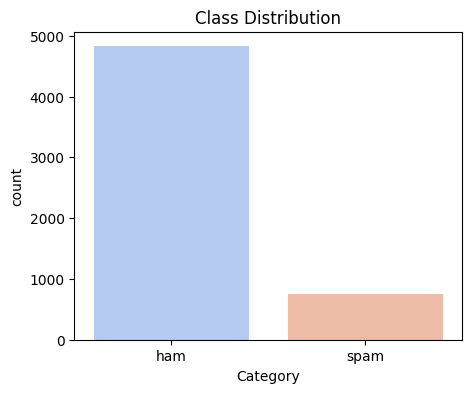

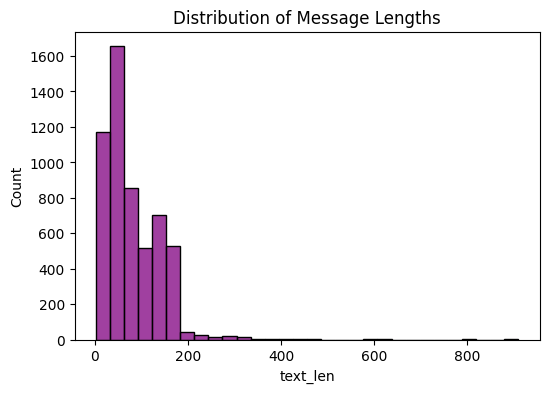

In [5]:
print("\nMissing values:\n", df.isna().sum())

# Class distribution
plt.figure(figsize=(5,4))
sns.countplot(x='Category', data=df, palette='coolwarm')
plt.title('Class Distribution')
plt.show()

# Convert label to numeric
df['label'] = df['Category'].astype(str).str.lower().map({'ham':0, 'spam':1})

# Basic text stats
df['text_len'] = df['Message'].apply(lambda x: len(str(x)))
plt.figure(figsize=(6,4))
sns.histplot(df['text_len'], bins=30, color='purple')
plt.title('Distribution of Message Lengths')
plt.show()

In [7]:

X = df['Message']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train size:", len(X_train), "Test size:", len(X_test))

Train size: 4457 Test size: 1115



 Defining Encoders and Models


In [9]:

encoders = {
    "CountVectorizer": CountVectorizer(stop_words='english'),
    "TF-IDF": TfidfVectorizer(stop_words='english'),
    "HashingVectorizer": HashingVectorizer(n_features=2**16, alternate_sign=False)
}

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, solver='liblinear'),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Linear SVM": LinearSVC()
}

##

In [10]:

results = []

for enc_name, enc in encoders.items():
    for model_name, model in models.items():
        pipeline = Pipeline([
            ('vectorizer', enc),
            ('classifier', model)
        ])
        # 5-fold cross-validation using F1-score
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        scores = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='f1')
        results.append({
            'Encoder': enc_name,
            'Model': model_name,
            'F1_mean': np.mean(scores).round(4),
            'F1_std': np.std(scores).round(4)
        })
        print(f"{enc_name} + {model_name} --> F1: {np.mean(scores):.4f}")

results_df = pd.DataFrame(results)
print("\nCross-validation Results:")
display(results_df.sort_values(by='F1_mean', ascending=False))





CountVectorizer + Logistic Regression --> F1: 0.9161
CountVectorizer + Random Forest --> F1: 0.8993
CountVectorizer + Linear SVM --> F1: 0.9266
TF-IDF + Logistic Regression --> F1: 0.8070
TF-IDF + Random Forest --> F1: 0.8967
TF-IDF + Linear SVM --> F1: 0.9401
HashingVectorizer + Logistic Regression --> F1: 0.8529
HashingVectorizer + Random Forest --> F1: 0.8809
HashingVectorizer + Linear SVM --> F1: 0.9323

Cross-validation Results:


,Encoder,Model,F1_mean,F1_std
5,TF-IDF,Linear SVM,0.9401,0.0109
8,HashingVectorizer,Linear SVM,0.9323,0.0121
2,CountVectorizer,Linear SVM,0.9266,0.0168
0,CountVectorizer,Logistic Regression,0.9161,0.0162
1,CountVectorizer,Random Forest,0.8993,0.0214
4,TF-IDF,Random Forest,0.8967,0.0233
7,HashingVectorizer,Random Forest,0.8809,0.0180
6,HashingVectorizer,Logistic Regression,0.8529,0.0199
3,TF-IDF,Logistic Regression,0.8070,0.0259


 ## Selecting Bes model and Evaluating on Test Set

In [11]:
best_row = results_df.iloc[results_df['F1_mean'].idxmax()]
best_encoder = encoders[best_row['Encoder']]
best_model = models[best_row['Model']]

print(f"\nBest combination: {best_row['Encoder']} + {best_row['Model']}")

# Fit on full train and evaluate on test
final_pipeline = Pipeline([
    ('vectorizer', best_encoder),
    ('classifier', best_model)
])
final_pipeline.fit(X_train, y_train)
y_pred = final_pipeline.predict(X_test)

# Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nTest Set Performance:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Best combination: TF-IDF + Linear SVM

Test Set Performance:
Accuracy:  0.9821
Precision: 0.9850
Recall:    0.8792
F1-score:  0.9291

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       0.98      0.88      0.93       149

    accuracy                           0.98      1115
   macro avg       0.98      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



## Confusion Matrix on Test Set

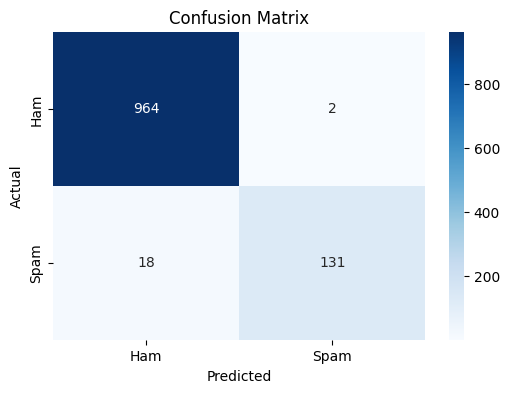

In [12]:

from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Summary Table

In [13]:

summary = pd.DataFrame([{
    'Encoder': best_row['Encoder'],
    'Model': best_row['Model'],
    'Accuracy': acc,
    'Precision': prec,
    'Recall': rec,
    'F1-score': f1
}])
print("\nFinal Selected Model (based on F1-score):")
display(summary)


Final Selected Model (based on F1-score):


,Encoder,Model,Accuracy,Precision,Recall,F1-score
0,TF-IDF,Linear SVM,0.982063,0.984962,0.879195,0.929078


## Saving the Best Model

In [14]:

import joblib
import json
from pathlib import Path

# Create models directory if it doesn't exist
models_dir = Path("models")
models_dir.mkdir(parents=True, exist_ok=True)

# Save trained pipeline
model_path = models_dir / "best_model.joblib"
joblib.dump(final_pipeline, model_path)

# Save metadata (model details + metrics)
metadata = {
    "encoder": best_row['Encoder'],
    "model": best_row['Model'],
    "accuracy": acc,
    "precision": prec,
    "recall": rec,
    "f1_score": f1
}

with open(models_dir / "metadata.json", "w") as f:
    json.dump(metadata, f, indent=4)

print(f" Model and metadata saved to {models_dir}/")


✅ Model and metadata saved to models/
